## Загрузим нужные библиотеки

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
import numpy as np
from collections import Counter
from nltk.stem.snowball import SnowballStemmer, PorterStemmer
from tqdm.notebook import tqdm
import re
from catboost import CatBoostClassifier
from sklearn.utils.class_weight import compute_class_weight

tqdm.pandas()
%matplotlib inline

In [2]:
df_train = pd.read_csv("train_dataset_train.csv")

## Рассмотрим датасет по ближе

In [3]:
df_train.head(3)

,RecordNo,Название книги,Автор,Ссылка на литрес,Рейтинг,Количество оценок,Количество отзывов,Имя читателя,Оценка книги читателем (из 5 баллов),Отзыв,Лайки на отзыв,Дислайки на отзыв,Релевантность,Таксономия релевантные,Таксономия не релевантные,Длина отзыва,Ценности
0,6145,Зулейха открывает глаза,Гузель Яхина,https://www.litres.ru/guzel-yahina/zuleyha-otk...,4.7,3922,408,Айгуль Ляпина,5.0,Рекомендую книгу в прочтению/прослушиванию. Ес...,0,3,0,0,0,0,0
1,7006,Зулейха открывает глаза,Гузель Яхина,https://www.litres.ru/guzel-yahina/zuleyha-otk...,4.6,24719,2103,Olga T,5.0,"Удивительно, что сейчас возникает ТАКАЯ литера...",0,1,0,0,0,0,1
2,1124,Дети мои,Гузель Яхина,https://www.litres.ru/guzel-yahina/deti-moi/,4.4,8032,702,Кирилл Чириков,5.0,"Душевно, жизненно, чувственно, проникновенно!!...",0,0,0,1,0,0,1


In [4]:
df_train.shape

(4839, 17)

In [5]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4839 entries, 0 to 4838
Data columns (total 17 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   RecordNo                              4839 non-null   int64  
 1   Название книги                        4839 non-null   object 
 2   Автор                                 4839 non-null   object 
 3   Ссылка на литрес                      4839 non-null   object 
 4   Рейтинг                               4839 non-null   float64
 5   Количество оценок                     4839 non-null   int64  
 6   Количество отзывов                    4839 non-null   int64  
 7   Имя читателя                          4839 non-null   object 
 8   Оценка книги читателем (из 5 баллов)  4070 non-null   float64
 9   Отзыв                                 4839 non-null   object 
 10  Лайки на отзыв                        4839 non-null   int64  
 11  Дислайки на отзыв

## Добавим новых признаков

In [6]:
df_train['latin_name'] = df_train['Имя читателя'].apply(lambda x: len(re.findall('[a-zA-Z]', x)) > 0).astype(int)

In [7]:
stemmer_ru = SnowballStemmer("russian") 
stemmer_en = PorterStemmer(ignore_stopwords = False) 

In [8]:
def stem(word):
    return stemmer_ru.stem(stemmer_en.stem(word))

In [9]:
df_train['total_len'] = df_train['Отзыв'].fillna(' ').progress_apply(len)
df_train['Отзыв'] = df_train['Отзыв'].fillna('').progress_apply(lambda x: ' '.join(filter(lambda x: len(x) > 0, map(stem, 
                                                                                    re.split(r'[\[\]\|!\n\{\}` ,"\'\_\-.()\?=0-9//%:\~*]', 
                                                                                             x.lower())))))
df_train['sign_len'] = df_train['Отзыв'].fillna('').progress_apply(len)
df_train['sign_frac'] = df_train['sign_len']/df_train['total_len']
df_train['count_'] = df_train['Отзыв'].fillna('').progress_apply(lambda x: len(x.split()))
df_train['avg_len'] = df_train['total_len']/df_train['count_']

  0%|          | 0/4839 [00:00<?, ?it/s]

  0%|          | 0/4839 [00:00<?, ?it/s]

  0%|          | 0/4839 [00:00<?, ?it/s]

  0%|          | 0/4839 [00:00<?, ?it/s]

In [10]:
df_train.head()

,RecordNo,Название книги,Автор,Ссылка на литрес,Рейтинг,Количество оценок,Количество отзывов,Имя читателя,Оценка книги читателем (из 5 баллов),Отзыв,...,Таксономия релевантные,Таксономия не релевантные,Длина отзыва,Ценности,latin_name,total_len,sign_len,sign_frac,count_,avg_len
0,6145,Зулейха открывает глаза,Гузель Яхина,https://www.litres.ru/guzel-yahina/zuleyha-otk...,4.7,3922,408,Айгуль Ляпина,5.0,рекоменд книг в прочтен прослушиван ест о чем ...,...,0,0,0,0,0,157,130,0.828025,24,6.541667
1,7006,Зулейха открывает глаза,Гузель Яхина,https://www.litres.ru/guzel-yahina/zuleyha-otk...,4.6,24719,2103,Olga T,5.0,удивительн что сейчас возника так литератур за...,...,0,0,0,1,1,283,223,0.787986,40,7.075000
2,1124,Дети мои,Гузель Яхина,https://www.litres.ru/guzel-yahina/deti-moi/,4.4,8032,702,Кирилл Чириков,5.0,душевн жизнен чувствен проникновен истор котор...,...,1,0,0,1,0,278,197,0.708633,35,7.942857
3,4716,ПОСТ,Дмитрий Глуховский,https://www.litres.ru/dmitriy-gluhovskiy/post/,3.9,430,48,Kimetov Oleg,5.0,очен понрав прич понрав больш «метро» «метро» ...,...,1,0,0,0,1,342,273,0.798246,52,6.576923
4,2946,ПОСТ,Дмитрий Глуховский,https://www.litres.ru/dmitriy-gluhovskiy/post-...,4.4,832,113,Сергей Никитин,5.0,крут автор и он же чтец – ген прослуша на одн ...,...,0,0,0,0,0,177,144,0.813559,29,6.103448


In [11]:
def count_instances(x, word):
    return (' '+x.lower()+' ').count(' '+word+' ')

In [12]:
full = ' '.join(df_train['Отзыв'].dropna())
name_set = Counter(full.split())

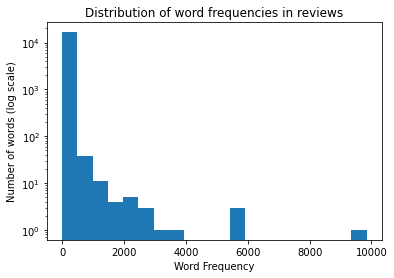

In [13]:
plt.hist(name_set.values(), 20)
plt.yscale('log')
plt.ylabel('Number of words (log scale)')
plt.xlabel('Word Frequency')
plt.title('Distribution of word frequencies in reviews')
plt.show()

In [14]:
words = list(set([x for x in name_set if name_set[x] > 5]))

In [15]:
len(words)

3141

In [16]:
bigram_set = Counter([a+' '+b for a, b in zip(full.split()[:-1], full.split()[1:])])

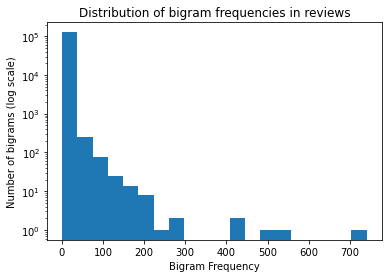

In [17]:
plt.hist(bigram_set.values(), 20)
plt.yscale('log')
plt.ylabel('Number of bigrams (log scale)')
plt.xlabel('Bigram Frequency')
plt.title('Distribution of bigram frequencies in reviews')
plt.show()

In [18]:
bigrams = list(set([x for x in bigram_set if bigram_set[x] > 5]))

In [19]:
len(bigrams)

4845

In [20]:
df_train = pd.concat([df_train] + [pd.DataFrame({word: df_train["Отзыв"].map(lambda x: 
                                                                                  count_instances(x, word))})
                      for word in tqdm(words)] + [pd.DataFrame({word: 
                                                                        df_train["Отзыв"].map(lambda x: 
                                                                                                count_instances(x, 
                                                                                                                word))})
                      for word in tqdm(bigrams)], axis=1)

  0%|          | 0/3141 [00:00<?, ?it/s]

  0%|          | 0/4845 [00:00<?, ?it/s]

In [21]:
word_lengths = pd.Series({word: len(word) for word in words})
bigram_lengths = pd.Series({word: len(word) for word in bigrams})

In [22]:
df_train['word_count'] = df_train[[word for word in words]].sum(axis=1)
df_train['word_frac'] = df_train['word_count']/(df_train['count_'] +0.0001)
df_train['word_total_len'] = (df_train[[word for word in words]]*word_lengths).sum(axis=1)
df_train['word_avg_len'] = df_train['word_total_len']/(df_train['word_count'] +0.0001)

In [23]:
df_train['bigram_count'] = df_train[[word for word in bigrams]].sum(axis=1)
df_train['bigram_frac'] = df_train['bigram_count']/(df_train['count_'] +0.0001)
df_train['bigram_total_len'] = (df_train[[word for word in bigrams]]*bigram_lengths).sum(axis=1)
df_train['bigram_avg_len'] = df_train['bigram_total_len']/(df_train['bigram_count'] +0.0001)

In [24]:
df_train['total_count'] = df_train['word_count']+df_train['bigram_count']
df_train['max_count'] = df_train['word_count']-df_train['bigram_count']
df_train['sign_total_len'] = df_train['word_total_len']+df_train['bigram_total_len']
df_train['sign_avg_len'] = df_train['sign_total_len']/(df_train['total_count'] + 0.001)

In [25]:
df_train = df_train.fillna(0)

In [26]:
df_train.head()

,RecordNo,Название книги,Автор,Ссылка на литрес,Рейтинг,Количество оценок,Количество отзывов,Имя читателя,Оценка книги читателем (из 5 баллов),Отзыв,...,word_total_len,word_avg_len,bigram_count,bigram_frac,bigram_total_len,bigram_avg_len,total_count,max_count,sign_total_len,sign_avg_len
0,6145,Зулейха открывает глаза,Гузель Яхина,https://www.litres.ru/guzel-yahina/zuleyha-otk...,4.7,3922,408,Айгуль Ляпина,5.0,рекоменд книг в прочтен прослушиван ест о чем ...,...,87,3.954527,10,0.416665,67,6.699933,32,12,154,4.812350
1,7006,Зулейха открывает глаза,Гузель Яхина,https://www.litres.ru/guzel-yahina/zuleyha-otk...,4.6,24719,2103,Olga T,5.0,удивительн что сейчас возника так литератур за...,...,175,4.487168,16,0.399999,149,9.312442,55,23,324,5.890802
2,1124,Дети мои,Гузель Яхина,https://www.litres.ru/guzel-yahina/deti-moi/,4.4,8032,702,Кирилл Чириков,5.0,душевн жизнен чувствен проникновен истор котор...,...,159,4.676457,13,0.371428,110,8.461473,47,21,269,5.723282
3,4716,ПОСТ,Дмитрий Глуховский,https://www.litres.ru/dmitriy-gluhovskiy/post/,3.9,430,48,Kimetov Oleg,5.0,очен понрав прич понрав больш «метро» «метро» ...,...,183,3.893609,19,0.365384,137,7.210488,66,28,320,4.848411
4,2946,ПОСТ,Дмитрий Глуховский,https://www.litres.ru/dmitriy-gluhovskiy/post-...,4.4,832,113,Сергей Никитин,5.0,крут автор и он же чтец – ген прослуша на одн ...,...,110,3.928557,11,0.379309,87,7.909019,39,17,197,5.051153


## Выделим выборки для каждой целевой переменной

In [27]:
X = df_train.drop(['Ссылка на литрес', 'Имя читателя', 'Отзыв', 
                   'Релевантность', 'Таксономия релевантные', 
                   'Таксономия не релевантные', 'Длина отзыва', 'Ценности'], axis = 1)

y = df_train[['Релевантность', 'Таксономия релевантные', 
              'Таксономия не релевантные', 'Длина отзыва', 'Ценности']]

In [28]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4839 entries, 0 to 4838
Columns: 8013 entries, RecordNo to sign_avg_len
dtypes: float64(9), int64(8002), object(2)
memory usage: 295.8+ MB


In [29]:
cat_cols = list(filter(lambda x: X.dtypes[x] != 'int64' and X.dtypes[x] != 'float64', 
                       range(len(X.dtypes))))

In [30]:
cat_cols

[1, 2]

In [31]:
X_r_train, X_r_test, y_r_train, y_r_test = train_test_split(X, y['Релевантность'], test_size=0.3, 
                                                            random_state=42, stratify=y['Релевантность'])

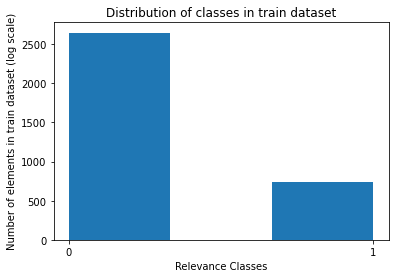

In [32]:
plt.hist(y_r_train, 3)
plt.title('Distribution of classes in train dataset')
plt.ylabel('Number of elements in train dataset (log scale)')
plt.xlabel('Relevance Classes')
plt.xticks([0, 1])
plt.ylim(bottom=0)
plt.show()

In [33]:
classes_r = np.unique(y_r_train)
weights_r = compute_class_weight(class_weight='balanced', classes=classes_r, y=y_r_train)
class_weights_r = dict(zip(classes_r, weights_r))
class_weights_r

{0: 0.6400226757369615, 1: 2.285425101214575}

In [34]:
X_tr_train, X_tr_test, y_tr_train, y_tr_test = train_test_split(X, y['Таксономия релевантные'], test_size=0.3, 
                                                            random_state=42, stratify=y['Таксономия релевантные'])

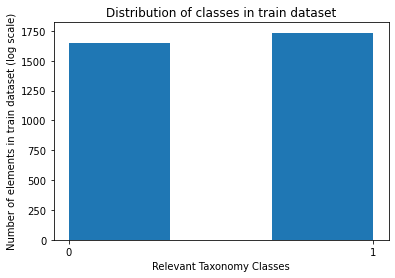

In [35]:
plt.hist(y_tr_train, 3)
plt.title('Distribution of classes in train dataset')
plt.ylabel('Number of elements in train dataset (log scale)')
plt.xlabel('Relevant Taxonomy Classes')
plt.xticks([0, 1])
plt.ylim(bottom=0)
plt.show()

In [36]:
classes_tr = np.unique(y_tr_train)
weights_tr = compute_class_weight(class_weight='balanced', classes=classes_tr, y=y_tr_train)
class_weights_tr = dict(zip(classes_tr, weights_tr))
class_weights_tr

{0: 1.0251210653753027, 1: 0.9760806916426513}

In [37]:
X_tn_train, X_tn_test, y_tn_train, y_tn_test = train_test_split(X, y['Таксономия не релевантные'], test_size=0.3, 
                                                            random_state=42, stratify=y['Таксономия не релевантные'])

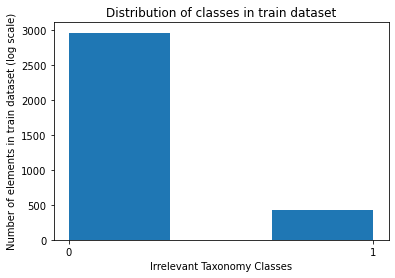

In [38]:
plt.hist(y_tn_train, 3)
plt.title('Distribution of classes in train dataset')
plt.ylabel('Number of elements in train dataset (log scale)')
plt.xlabel('Irrelevant Taxonomy Classes')
plt.xticks([0, 1])
plt.ylim(bottom=0)
plt.show()

In [39]:
classes_tn = np.unique(y_tn_train)
weights_tn = compute_class_weight(class_weight='balanced', classes=classes_tn, y=y_tn_train)
class_weights_tn = dict(zip(classes_tn, weights_tn))
class_weights_tn

{0: 0.5727088265133581, 1: 3.938372093023256}

In [40]:
X_l_train, X_l_test, y_l_train, y_l_test = train_test_split(X, y['Длина отзыва'], test_size=0.3, 
                                                            random_state=42, stratify=y['Длина отзыва'])

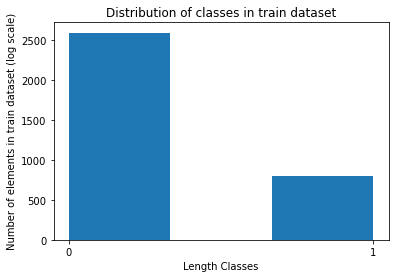

In [41]:
plt.hist(y_l_train, 3)
plt.title('Distribution of classes in train dataset')
plt.ylabel('Number of elements in train dataset (log scale)')
plt.xlabel('Length Classes')
plt.xticks([0, 1])
plt.ylim(bottom=0)
plt.show()

In [42]:
classes_l = np.unique(y_l_train)
weights_l = compute_class_weight(class_weight='balanced', classes=classes_l, y=y_l_train)
class_weights_l = dict(zip(classes_l, weights_l))
class_weights_l

{0: 0.6533564814814815, 1: 2.130188679245283}

In [43]:
X_v_train, X_v_test, y_v_train, y_v_test = train_test_split(X, y['Ценности'], test_size=0.3, 
                                                            random_state=42, stratify=y['Ценности'])

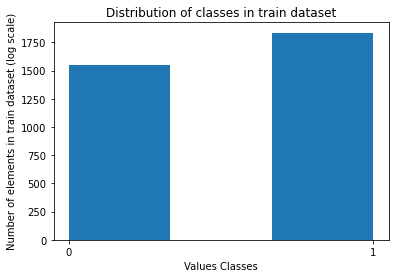

In [47]:
plt.hist(y_v_train, 3)
plt.title('Distribution of classes in train dataset')
plt.ylabel('Number of elements in train dataset (log scale)')
plt.xlabel('Values Classes')
plt.xticks([0, 1])
plt.ylim(bottom=0)
plt.show()

In [48]:
classes_v = np.unique(y_v_train)
weights_v = compute_class_weight(class_weight='balanced', classes=classes_v, y=y_v_train)
class_weights_v = dict(zip(classes_v, weights_v))
class_weights_v

{0: 1.0918762088974856, 1: 0.9223856209150327}

## Обучение модели

In [49]:
params = {'loss_function':'MultiClass',
          'eval_metric':'TotalF1:average=Macro',
          'cat_features': cat_cols,
          'custom_metric':'Recall',
          'class_weights': class_weights_r,
          'verbose': 200,
          'random_seed': 0,
          'iterations': 100000,
          'depth': 3,
          'l2_leaf_reg': 10000,
          'random_strength': 10000,
         }
model_r = CatBoostClassifier(**params)
model_r.fit(X_r_train, y_r_train,
          eval_set=(X_r_test, y_r_test),
          use_best_model=True,
          plot=True
         )

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.5214666	test: 0.4924560	best: 0.4924560 (0)	total: 7.8ms	remaining: 12m 59s
200:	learn: 0.4914159	test: 0.5080136	best: 0.5505414 (50)	total: 1.56s	remaining: 12m 56s
400:	learn: 0.5947077	test: 0.5818599	best: 0.5850122 (396)	total: 3.06s	remaining: 12m 40s
600:	learn: 0.6501515	test: 0.6241581	best: 0.6275018 (591)	total: 4.58s	remaining: 12m 38s
800:	learn: 0.6510679	test: 0.6302077	best: 0.6306992 (701)	total: 6.37s	remaining: 13m 8s
1000:	learn: 0.6574680	test: 0.6278383	best: 0.6322685 (865)	total: 8.21s	remaining: 13m 32s
1200:	learn: 0.6643458	test: 0.6311805	best: 0.6322685 (865)	total: 9.88s	remaining: 13m 32s
1400:	learn: 0.6696684	test: 0.6336739	best: 0.6340984 (1307)	total: 11.5s	remaining: 13m 32s
1600:	learn: 0.6737407	test: 0.6395086	best: 0.6402983 (1589)	total: 13.2s	remaining: 13m 33s
1800:	learn: 0.6791143	test: 0.6449170	best: 0.6457679 (1744)	total: 14.8s	remaining: 13m 29s
2000:	learn: 0.6845125	test: 0.6543717	best: 0.6543717 (1999)	total: 16.5s	rem

17400:	learn: 0.7539601	test: 0.7035593	best: 0.7047205 (16727)	total: 3m 1s	remaining: 14m 19s
17600:	learn: 0.7541488	test: 0.7035593	best: 0.7047205 (16727)	total: 3m 4s	remaining: 14m 21s
17800:	learn: 0.7550131	test: 0.7031240	best: 0.7047205 (16727)	total: 3m 6s	remaining: 14m 20s
18000:	learn: 0.7560661	test: 0.7031240	best: 0.7047205 (16727)	total: 3m 9s	remaining: 14m 22s
18200:	learn: 0.7562549	test: 0.7031240	best: 0.7047205 (16727)	total: 3m 11s	remaining: 14m 21s
18400:	learn: 0.7562549	test: 0.7026886	best: 0.7047205 (16727)	total: 3m 14s	remaining: 14m 21s
18600:	learn: 0.7567413	test: 0.7042847	best: 0.7047205 (16727)	total: 3m 17s	remaining: 14m 22s
18800:	learn: 0.7577941	test: 0.7042847	best: 0.7047205 (16727)	total: 3m 19s	remaining: 14m 22s
19000:	learn: 0.7576052	test: 0.7058790	best: 0.7058790 (18822)	total: 3m 22s	remaining: 14m 23s
19200:	learn: 0.7577941	test: 0.7063153	best: 0.7063153 (19126)	total: 3m 25s	remaining: 14m 22s
19400:	learn: 0.7581719	test: 0.70

34400:	learn: 0.7835968	test: 0.7192342	best: 0.7208269 (33553)	total: 7m 21s	remaining: 14m 1s
34600:	learn: 0.7835968	test: 0.7192342	best: 0.7208269 (33553)	total: 7m 24s	remaining: 13m 59s
34800:	learn: 0.7835968	test: 0.7192342	best: 0.7208269 (33553)	total: 7m 28s	remaining: 14m
35000:	learn: 0.7837860	test: 0.7180759	best: 0.7208269 (33553)	total: 7m 30s	remaining: 13m 56s
35200:	learn: 0.7837860	test: 0.7196705	best: 0.7208269 (33553)	total: 7m 33s	remaining: 13m 54s
35400:	learn: 0.7837860	test: 0.7185117	best: 0.7208269 (33553)	total: 7m 37s	remaining: 13m 55s
35600:	learn: 0.7837860	test: 0.7185117	best: 0.7208269 (33553)	total: 7m 41s	remaining: 13m 53s
35800:	learn: 0.7835968	test: 0.7189474	best: 0.7208269 (33553)	total: 7m 45s	remaining: 13m 54s
36000:	learn: 0.7843535	test: 0.7189474	best: 0.7208269 (33553)	total: 7m 47s	remaining: 13m 50s
36200:	learn: 0.7843535	test: 0.7189474	best: 0.7208269 (33553)	total: 7m 50s	remaining: 13m 49s
36400:	learn: 0.7845427	test: 0.718

51400:	learn: 0.7945576	test: 0.7200961	best: 0.7237344 (49423)	total: 12m 46s	remaining: 12m 4s
51600:	learn: 0.7950426	test: 0.7200961	best: 0.7237344 (49423)	total: 12m 50s	remaining: 12m 2s
51800:	learn: 0.7954209	test: 0.7200961	best: 0.7237344 (49423)	total: 12m 54s	remaining: 12m
52000:	learn: 0.7954209	test: 0.7200961	best: 0.7237344 (49423)	total: 13m	remaining: 12m
52200:	learn: 0.7956100	test: 0.7200961	best: 0.7237344 (49423)	total: 13m 4s	remaining: 11m 58s
52400:	learn: 0.7957991	test: 0.7189253	best: 0.7237344 (49423)	total: 13m 8s	remaining: 11m 56s
52600:	learn: 0.7961773	test: 0.7189253	best: 0.7237344 (49423)	total: 13m 14s	remaining: 11m 55s
52800:	learn: 0.7968516	test: 0.7189253	best: 0.7237344 (49423)	total: 13m 18s	remaining: 11m 53s
53000:	learn: 0.7968516	test: 0.7189253	best: 0.7237344 (49423)	total: 13m 22s	remaining: 11m 51s
53200:	learn: 0.7975257	test: 0.7193588	best: 0.7237344 (49423)	total: 13m 26s	remaining: 11m 49s
53400:	learn: 0.7975257	test: 0.7193

68400:	learn: 0.8049749	test: 0.7191699	best: 0.7251712 (57800)	total: 19m 4s	remaining: 8m 48s
68600:	learn: 0.8049749	test: 0.7191699	best: 0.7251712 (57800)	total: 19m 11s	remaining: 8m 47s
68800:	learn: 0.8049749	test: 0.7207813	best: 0.7251712 (57800)	total: 19m 16s	remaining: 8m 44s
69000:	learn: 0.8049749	test: 0.7191699	best: 0.7251712 (57800)	total: 19m 19s	remaining: 8m 41s
69200:	learn: 0.8051642	test: 0.7207813	best: 0.7251712 (57800)	total: 19m 25s	remaining: 8m 38s
69400:	learn: 0.8051642	test: 0.7207813	best: 0.7251712 (57800)	total: 19m 30s	remaining: 8m 36s
69600:	learn: 0.8049749	test: 0.7207813	best: 0.7251712 (57800)	total: 19m 35s	remaining: 8m 33s
69800:	learn: 0.8056487	test: 0.7207813	best: 0.7251712 (57800)	total: 19m 40s	remaining: 8m 30s
70000:	learn: 0.8058380	test: 0.7207813	best: 0.7251712 (57800)	total: 19m 44s	remaining: 8m 27s
70200:	learn: 0.8062165	test: 0.7223909	best: 0.7251712 (57800)	total: 19m 49s	remaining: 8m 24s
70400:	learn: 0.8062165	test: 0

85400:	learn: 0.8156861	test: 0.7261640	best: 0.7261640 (82173)	total: 26m 7s	remaining: 4m 28s
85600:	learn: 0.8156861	test: 0.7261640	best: 0.7261640 (82173)	total: 26m 13s	remaining: 4m 24s
85800:	learn: 0.8156861	test: 0.7261640	best: 0.7261640 (82173)	total: 26m 18s	remaining: 4m 21s
86000:	learn: 0.8156861	test: 0.7261640	best: 0.7261640 (82173)	total: 26m 21s	remaining: 4m 17s
86200:	learn: 0.8156861	test: 0.7261640	best: 0.7261640 (82173)	total: 26m 26s	remaining: 4m 13s
86400:	learn: 0.8150127	test: 0.7261640	best: 0.7261640 (82173)	total: 26m 31s	remaining: 4m 10s
86600:	learn: 0.8150127	test: 0.7261640	best: 0.7261640 (82173)	total: 26m 36s	remaining: 4m 7s
86800:	learn: 0.8153914	test: 0.7261640	best: 0.7261640 (82173)	total: 26m 41s	remaining: 4m 3s
87000:	learn: 0.8153914	test: 0.7261640	best: 0.7261640 (82173)	total: 26m 47s	remaining: 4m
87200:	learn: 0.8153914	test: 0.7261640	best: 0.7261640 (82173)	total: 26m 53s	remaining: 3m 56s
87400:	learn: 0.8153914	test: 0.72616

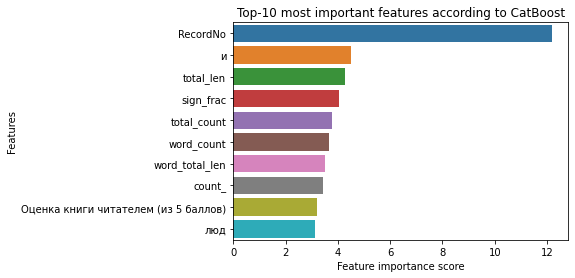

In [50]:
feature_importance_r = model_r.get_feature_importance()
feature_ranks_r = feature_importance_r.argsort()[::-1]
sns.barplot(y=X.columns[feature_ranks_r[:10]],x=feature_importance_r[feature_ranks_r[:10]])
plt.title('Top-10 most important features according to CatBoost')
plt.ylabel('Features')
plt.xlabel('Feature importance score')
plt.show()

In [51]:
params = {'loss_function':'MultiClass',
          'eval_metric':'TotalF1:average=Macro',
          'cat_features': cat_cols,
          'custom_metric':'Recall',
          'class_weights': class_weights_tr,
          'verbose': 200,
          'random_seed': 0,
          'iterations': 100000,
          'depth': 3,
          'l2_leaf_reg': 10000,
          'random_strength': 10000,
         }
model_tr = CatBoostClassifier(**params)
model_tr.fit(X_tr_train, y_tr_train,
          eval_set=(X_tr_test, y_tr_test),
          use_best_model=True,
          plot=True
         )

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.3793813	test: 0.3727001	best: 0.3727001 (0)	total: 11.5ms	remaining: 19m 13s
200:	learn: 0.5887884	test: 0.5593449	best: 0.5697910 (42)	total: 1.79s	remaining: 14m 50s
400:	learn: 0.5851642	test: 0.5556745	best: 0.5697910 (42)	total: 3.35s	remaining: 13m 51s
600:	learn: 0.8293218	test: 0.8292667	best: 0.8292667 (559)	total: 4.84s	remaining: 13m 20s
800:	learn: 0.8293218	test: 0.8292667	best: 0.8292667 (559)	total: 6.35s	remaining: 13m 6s
1000:	learn: 0.8293218	test: 0.8292667	best: 0.8292667 (559)	total: 7.88s	remaining: 12m 59s
1200:	learn: 0.8293218	test: 0.8292667	best: 0.8292667 (559)	total: 9.46s	remaining: 12m 58s
1400:	learn: 0.8293218	test: 0.8292667	best: 0.8292667 (559)	total: 11s	remaining: 12m 57s
1600:	learn: 0.8293218	test: 0.8292667	best: 0.8292667 (559)	total: 12.6s	remaining: 12m 54s
1800:	learn: 0.8293218	test: 0.8292667	best: 0.8292667 (559)	total: 14.2s	remaining: 12m 55s
2000:	learn: 0.8293218	test: 0.8292667	best: 0.8292667 (559)	total: 15.8s	remaining

17400:	learn: 0.8995810	test: 0.8891009	best: 0.8891009 (17070)	total: 2m 53s	remaining: 13m 45s
17600:	learn: 0.9010644	test: 0.8897976	best: 0.8897976 (17466)	total: 2m 56s	remaining: 13m 47s
17800:	learn: 0.9013609	test: 0.8918859	best: 0.8918859 (17687)	total: 2m 58s	remaining: 13m 46s
18000:	learn: 0.9019538	test: 0.8925814	best: 0.8925814 (17958)	total: 3m 1s	remaining: 13m 45s
18200:	learn: 0.9022502	test: 0.8946660	best: 0.8946660 (18200)	total: 3m 3s	remaining: 13m 46s
18400:	learn: 0.9025465	test: 0.8953603	best: 0.8953603 (18260)	total: 3m 6s	remaining: 13m 46s
18600:	learn: 0.9037313	test: 0.8967481	best: 0.8967481 (18434)	total: 3m 9s	remaining: 13m 49s
18800:	learn: 0.9046194	test: 0.8974415	best: 0.8974415 (18618)	total: 3m 11s	remaining: 13m 49s
19000:	learn: 0.9055071	test: 0.8981347	best: 0.8981347 (18985)	total: 3m 15s	remaining: 13m 51s
19200:	learn: 0.9055071	test: 0.8988275	best: 0.8988275 (19108)	total: 3m 17s	remaining: 13m 51s
19400:	learn: 0.9063943	test: 0.89

34400:	learn: 0.9237619	test: 0.9235817	best: 0.9235817 (34126)	total: 7m 3s	remaining: 13m 28s
34600:	learn: 0.9237619	test: 0.9235817	best: 0.9235817 (34126)	total: 7m 6s	remaining: 13m 26s
34800:	learn: 0.9237619	test: 0.9235817	best: 0.9235817 (34126)	total: 7m 10s	remaining: 13m 26s
35000:	learn: 0.9237619	test: 0.9235817	best: 0.9235817 (34126)	total: 7m 14s	remaining: 13m 26s
35200:	learn: 0.9237619	test: 0.9235817	best: 0.9235817 (34126)	total: 7m 17s	remaining: 13m 25s
35400:	learn: 0.9246411	test: 0.9242652	best: 0.9242652 (35369)	total: 7m 21s	remaining: 13m 25s
35600:	learn: 0.9246411	test: 0.9242652	best: 0.9242652 (35369)	total: 7m 24s	remaining: 13m 24s
35800:	learn: 0.9249341	test: 0.9242652	best: 0.9242652 (35369)	total: 7m 27s	remaining: 13m 23s
36000:	learn: 0.9249341	test: 0.9242652	best: 0.9242652 (35369)	total: 7m 31s	remaining: 13m 22s
36200:	learn: 0.9249341	test: 0.9242652	best: 0.9242652 (35369)	total: 7m 34s	remaining: 13m 20s
36400:	learn: 0.9249341	test: 0.

51400:	learn: 0.9287400	test: 0.9283622	best: 0.9283622 (47121)	total: 12m 7s	remaining: 11m 28s
51600:	learn: 0.9287400	test: 0.9283622	best: 0.9283622 (47121)	total: 12m 12s	remaining: 11m 26s
51800:	learn: 0.9287400	test: 0.9283622	best: 0.9283622 (47121)	total: 12m 17s	remaining: 11m 26s
52000:	learn: 0.9287400	test: 0.9283622	best: 0.9283622 (47121)	total: 12m 21s	remaining: 11m 24s
52200:	learn: 0.9287400	test: 0.9283622	best: 0.9283622 (47121)	total: 12m 29s	remaining: 11m 26s
52400:	learn: 0.9287400	test: 0.9283622	best: 0.9283622 (47121)	total: 12m 35s	remaining: 11m 26s
52600:	learn: 0.9287400	test: 0.9283622	best: 0.9283622 (47121)	total: 12m 39s	remaining: 11m 24s
52800:	learn: 0.9287400	test: 0.9283622	best: 0.9283622 (47121)	total: 12m 43s	remaining: 11m 22s
53000:	learn: 0.9287400	test: 0.9283622	best: 0.9283622 (47121)	total: 12m 47s	remaining: 11m 21s
53200:	learn: 0.9287400	test: 0.9283622	best: 0.9283622 (47121)	total: 12m 51s	remaining: 11m 18s
53400:	learn: 0.92874

68400:	learn: 0.9328225	test: 0.9338141	best: 0.9338141 (67990)	total: 18m 23s	remaining: 8m 29s
68600:	learn: 0.9328225	test: 0.9338141	best: 0.9338141 (67990)	total: 18m 28s	remaining: 8m 27s
68800:	learn: 0.9328225	test: 0.9338141	best: 0.9338141 (67990)	total: 18m 33s	remaining: 8m 24s
69000:	learn: 0.9328225	test: 0.9338141	best: 0.9338141 (67990)	total: 18m 37s	remaining: 8m 22s
69200:	learn: 0.9328225	test: 0.9344948	best: 0.9344948 (69091)	total: 18m 41s	remaining: 8m 19s
69400:	learn: 0.9328225	test: 0.9344948	best: 0.9344948 (69091)	total: 18m 44s	remaining: 8m 15s
69600:	learn: 0.9328225	test: 0.9344948	best: 0.9344948 (69091)	total: 18m 49s	remaining: 8m 13s
69800:	learn: 0.9328225	test: 0.9344948	best: 0.9344948 (69091)	total: 18m 53s	remaining: 8m 10s
70000:	learn: 0.9328225	test: 0.9344948	best: 0.9344948 (69091)	total: 18m 58s	remaining: 8m 7s
70200:	learn: 0.9328225	test: 0.9344948	best: 0.9344948 (69091)	total: 19m 2s	remaining: 8m 5s
70400:	learn: 0.9328225	test: 0.9

85400:	learn: 0.9354490	test: 0.9371923	best: 0.9378955 (75306)	total: 25m 3s	remaining: 4m 17s
85600:	learn: 0.9354393	test: 0.9371923	best: 0.9378955 (75306)	total: 25m 9s	remaining: 4m 13s
85800:	learn: 0.9354393	test: 0.9371923	best: 0.9378955 (75306)	total: 25m 14s	remaining: 4m 10s
86000:	learn: 0.9354393	test: 0.9371923	best: 0.9378955 (75306)	total: 25m 18s	remaining: 4m 7s
86200:	learn: 0.9354393	test: 0.9378719	best: 0.9378955 (75306)	total: 25m 25s	remaining: 4m 4s
86400:	learn: 0.9354393	test: 0.9378719	best: 0.9378955 (75306)	total: 25m 30s	remaining: 4m
86600:	learn: 0.9354393	test: 0.9378719	best: 0.9378955 (75306)	total: 25m 36s	remaining: 3m 57s
86800:	learn: 0.9354393	test: 0.9378719	best: 0.9378955 (75306)	total: 25m 41s	remaining: 3m 54s
87000:	learn: 0.9354393	test: 0.9378719	best: 0.9378955 (75306)	total: 25m 47s	remaining: 3m 51s
87200:	learn: 0.9354393	test: 0.9378719	best: 0.9378955 (75306)	total: 25m 52s	remaining: 3m 47s
87400:	learn: 0.9354393	test: 0.937871

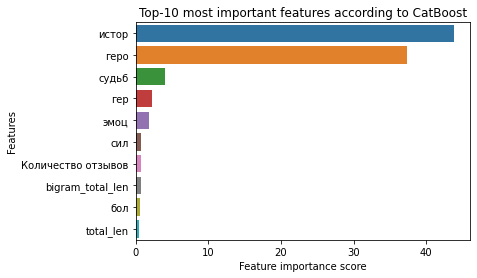

In [52]:
feature_importance_tr = model_tr.get_feature_importance()
feature_ranks_tr = feature_importance_tr.argsort()[::-1]
sns.barplot(y=X.columns[feature_ranks_tr[:10]],x=feature_importance_tr[feature_ranks_tr[:10]])
plt.title('Top-10 most important features according to CatBoost')
plt.ylabel('Features')
plt.xlabel('Feature importance score')
plt.show()

In [53]:
params = {'loss_function':'MultiClass',
          'eval_metric':'TotalF1:average=Macro',
          'cat_features': cat_cols,
          'custom_metric':'Recall',
          'class_weights': class_weights_tn,
          'verbose': 200,
          'random_seed': 0,
          'iterations': 100000,
          'depth': 3,
          'l2_leaf_reg': 10000,
          'random_strength': 10000,
         }
model_tn = CatBoostClassifier(**params)
model_tn.fit(X_tn_train, y_tn_train,
          eval_set=(X_tn_test, y_tn_test),
          use_best_model=True,
          plot=True
         )

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.5075474	test: 0.5069458	best: 0.5069458 (0)	total: 10.2ms	remaining: 16m 57s
200:	learn: 0.4048919	test: 0.4046506	best: 0.5069458 (0)	total: 1.83s	remaining: 15m 7s
400:	learn: 0.4439658	test: 0.4498180	best: 0.5069458 (0)	total: 3.38s	remaining: 13m 59s
600:	learn: 0.8021058	test: 0.7529663	best: 0.7529663 (600)	total: 4.97s	remaining: 13m 41s
800:	learn: 0.8034027	test: 0.7561654	best: 0.7561654 (602)	total: 6.52s	remaining: 13m 27s
1000:	learn: 0.8034027	test: 0.7561654	best: 0.7561654 (602)	total: 8.1s	remaining: 13m 20s
1200:	learn: 0.8034027	test: 0.7561654	best: 0.7561654 (602)	total: 9.64s	remaining: 13m 13s
1400:	learn: 0.8034027	test: 0.7561654	best: 0.7561654 (602)	total: 11.3s	remaining: 13m 12s
1600:	learn: 0.8034027	test: 0.7561654	best: 0.7561654 (602)	total: 13s	remaining: 13m 20s
1800:	learn: 0.8046978	test: 0.7593522	best: 0.7593522 (1777)	total: 15.4s	remaining: 13m 57s
2000:	learn: 0.8072829	test: 0.7625269	best: 0.7625269 (1996)	total: 17.1s	remaining:

17400:	learn: 0.8982512	test: 0.8501403	best: 0.8530159 (17155)	total: 3m 7s	remaining: 14m 50s
17600:	learn: 0.8982512	test: 0.8530159	best: 0.8530159 (17155)	total: 3m 10s	remaining: 14m 51s
17800:	learn: 0.8982512	test: 0.8530159	best: 0.8530159 (17155)	total: 3m 13s	remaining: 14m 51s
18000:	learn: 0.8982512	test: 0.8530159	best: 0.8530159 (17155)	total: 3m 15s	remaining: 14m 50s
18200:	learn: 0.8982512	test: 0.8530159	best: 0.8530159 (17155)	total: 3m 17s	remaining: 14m 48s
18400:	learn: 0.8994445	test: 0.8530159	best: 0.8530159 (17155)	total: 3m 21s	remaining: 14m 52s
18600:	learn: 0.8992771	test: 0.8530159	best: 0.8530159 (17155)	total: 3m 23s	remaining: 14m 50s
18800:	learn: 0.8991097	test: 0.8530159	best: 0.8530159 (17155)	total: 3m 26s	remaining: 14m 53s
19000:	learn: 0.8991097	test: 0.8530159	best: 0.8530159 (17155)	total: 3m 28s	remaining: 14m 50s
19200:	learn: 0.8991097	test: 0.8530159	best: 0.8530159 (17155)	total: 3m 31s	remaining: 14m 50s
19400:	learn: 0.9003021	test: 0

34400:	learn: 0.9192892	test: 0.8669124	best: 0.8669124 (33151)	total: 7m 20s	remaining: 13m 59s
34600:	learn: 0.9192892	test: 0.8669124	best: 0.8669124 (33151)	total: 7m 23s	remaining: 13m 57s
34800:	learn: 0.9192892	test: 0.8669124	best: 0.8669124 (33151)	total: 7m 24s	remaining: 13m 53s
35000:	learn: 0.9204693	test: 0.8697511	best: 0.8697511 (34883)	total: 7m 27s	remaining: 13m 51s
35200:	learn: 0.9204693	test: 0.8697511	best: 0.8697511 (34883)	total: 7m 31s	remaining: 13m 50s
35400:	learn: 0.9204693	test: 0.8697511	best: 0.8697511 (34883)	total: 7m 35s	remaining: 13m 51s
35600:	learn: 0.9204693	test: 0.8725843	best: 0.8725843 (35453)	total: 7m 38s	remaining: 13m 50s
35800:	learn: 0.9204693	test: 0.8725843	best: 0.8725843 (35453)	total: 7m 41s	remaining: 13m 48s
36000:	learn: 0.9203012	test: 0.8725843	best: 0.8725843 (35453)	total: 7m 46s	remaining: 13m 48s
36200:	learn: 0.9204693	test: 0.8754120	best: 0.8754120 (36147)	total: 7m 49s	remaining: 13m 47s
36400:	learn: 0.9203012	test: 

51400:	learn: 0.9308999	test: 0.8894733	best: 0.8894733 (49359)	total: 12m 41s	remaining: 11m 59s
51600:	learn: 0.9308999	test: 0.8894733	best: 0.8894733 (49359)	total: 12m 45s	remaining: 11m 57s
51800:	learn: 0.9307316	test: 0.8894733	best: 0.8898633 (51655)	total: 12m 49s	remaining: 11m 55s
52000:	learn: 0.9319070	test: 0.8898633	best: 0.8898633 (51655)	total: 12m 55s	remaining: 11m 55s
52200:	learn: 0.9319070	test: 0.8898633	best: 0.8898633 (51655)	total: 12m 59s	remaining: 11m 53s
52400:	learn: 0.9319070	test: 0.8898633	best: 0.8898633 (51655)	total: 13m 2s	remaining: 11m 51s
52600:	learn: 0.9319070	test: 0.8898633	best: 0.8898633 (51655)	total: 13m 6s	remaining: 11m 48s
52800:	learn: 0.9319070	test: 0.8898633	best: 0.8898633 (51655)	total: 13m 13s	remaining: 11m 49s
53000:	learn: 0.9320753	test: 0.8898633	best: 0.8898633 (51655)	total: 13m 17s	remaining: 11m 46s
53200:	learn: 0.9322436	test: 0.8898633	best: 0.8898633 (51655)	total: 13m 21s	remaining: 11m 44s
53400:	learn: 0.932243

68400:	learn: 0.9409643	test: 0.9065862	best: 0.9065862 (63400)	total: 18m 44s	remaining: 8m 39s
68600:	learn: 0.9409643	test: 0.9065862	best: 0.9065862 (63400)	total: 18m 48s	remaining: 8m 36s
68800:	learn: 0.9409643	test: 0.9065862	best: 0.9065862 (63400)	total: 18m 53s	remaining: 8m 34s
69000:	learn: 0.9423047	test: 0.9065862	best: 0.9065862 (63400)	total: 18m 58s	remaining: 8m 31s
69200:	learn: 0.9423047	test: 0.9065862	best: 0.9065862 (63400)	total: 19m 2s	remaining: 8m 28s
69400:	learn: 0.9423047	test: 0.9065862	best: 0.9065862 (63400)	total: 19m 7s	remaining: 8m 25s
69600:	learn: 0.9423047	test: 0.9065862	best: 0.9065862 (63400)	total: 19m 11s	remaining: 8m 23s
69800:	learn: 0.9423047	test: 0.9065862	best: 0.9065862 (63400)	total: 19m 16s	remaining: 8m 20s
70000:	learn: 0.9434762	test: 0.9065862	best: 0.9065862 (63400)	total: 19m 21s	remaining: 8m 17s
70200:	learn: 0.9434762	test: 0.9065862	best: 0.9065862 (63400)	total: 19m 26s	remaining: 8m 15s
70400:	learn: 0.9434762	test: 0.

85400:	learn: 0.9533407	test: 0.9180478	best: 0.9180478 (83042)	total: 25m 59s	remaining: 4m 26s
85600:	learn: 0.9533407	test: 0.9180478	best: 0.9180478 (83042)	total: 26m 7s	remaining: 4m 23s
85800:	learn: 0.9533407	test: 0.9180478	best: 0.9180478 (83042)	total: 26m 13s	remaining: 4m 20s
86000:	learn: 0.9533407	test: 0.9180478	best: 0.9180478 (83042)	total: 26m 19s	remaining: 4m 17s
86200:	learn: 0.9533407	test: 0.9180478	best: 0.9180478 (83042)	total: 26m 25s	remaining: 4m 13s
86400:	learn: 0.9535094	test: 0.9180478	best: 0.9180478 (83042)	total: 26m 30s	remaining: 4m 10s
86600:	learn: 0.9535094	test: 0.9180478	best: 0.9180478 (83042)	total: 26m 35s	remaining: 4m 6s
86800:	learn: 0.9536782	test: 0.9180478	best: 0.9180478 (83042)	total: 26m 41s	remaining: 4m 3s
87000:	learn: 0.9536782	test: 0.9180478	best: 0.9180478 (83042)	total: 26m 47s	remaining: 4m
87200:	learn: 0.9536782	test: 0.9180478	best: 0.9180478 (83042)	total: 26m 48s	remaining: 3m 56s
87400:	learn: 0.9536782	test: 0.91804

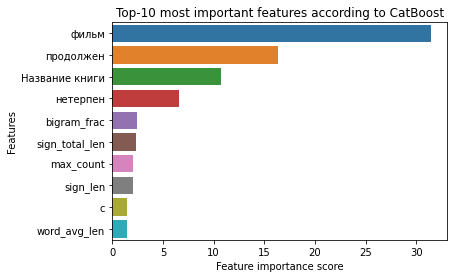

In [54]:
feature_importance_tn = model_tn.get_feature_importance()
feature_ranks_tn = feature_importance_tn.argsort()[::-1]
sns.barplot(y=X.columns[feature_ranks_tn[:10]],x=feature_importance_tn[feature_ranks_tn[:10]])
plt.title('Top-10 most important features according to CatBoost')
plt.ylabel('Features')
plt.xlabel('Feature importance score')
plt.show()

In [55]:
params = {'loss_function':'MultiClass',
          'eval_metric':'TotalF1:average=Macro',
          'cat_features': cat_cols,
          'custom_metric':'Recall',
          'class_weights': class_weights_l,
          'verbose': 200,
          'random_seed': 0,
          'iterations': 100000,
          'depth': 3,
          'l2_leaf_reg': 10000,
          'random_strength': 10000,
         }
model_l = CatBoostClassifier(**params)
model_l.fit(X_l_train, y_l_train,
          eval_set=(X_l_test, y_l_test),
          use_best_model=True,
          plot=True
         )

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.5202674	test: 0.5041401	best: 0.5041401 (0)	total: 9.71ms	remaining: 16m 11s
200:	learn: 0.5207568	test: 0.5096967	best: 0.6330040 (23)	total: 1.78s	remaining: 14m 46s
400:	learn: 0.5968151	test: 0.5721436	best: 0.6330040 (23)	total: 3.35s	remaining: 13m 51s
600:	learn: 0.6900669	test: 0.6643164	best: 0.6673787 (570)	total: 5.01s	remaining: 13m 48s
800:	learn: 0.6933793	test: 0.6643987	best: 0.6673787 (570)	total: 6.79s	remaining: 14m 1s
1000:	learn: 0.6954689	test: 0.6691646	best: 0.6691646 (964)	total: 8.63s	remaining: 14m 13s
1200:	learn: 0.6981269	test: 0.6711921	best: 0.6716983 (1065)	total: 10.4s	remaining: 14m 18s
1400:	learn: 0.6980348	test: 0.6735567	best: 0.6740629 (1372)	total: 12.2s	remaining: 14m 21s
1600:	learn: 0.6980952	test: 0.6745687	best: 0.6745687 (1444)	total: 14.1s	remaining: 14m 27s
1800:	learn: 0.6987403	test: 0.6732152	best: 0.6750742 (1625)	total: 15.9s	remaining: 14m 28s
2000:	learn: 0.6989552	test: 0.6755795	best: 0.6755795 (1984)	total: 17.8s	re

17400:	learn: 0.7398063	test: 0.6912424	best: 0.6920771 (14176)	total: 3m 12s	remaining: 15m 15s
17600:	learn: 0.7395996	test: 0.6912424	best: 0.6920771 (14176)	total: 3m 15s	remaining: 15m 13s
17800:	learn: 0.7402194	test: 0.6912424	best: 0.6920771 (14176)	total: 3m 17s	remaining: 15m 14s
18000:	learn: 0.7408388	test: 0.6922096	best: 0.6922096 (17909)	total: 3m 20s	remaining: 15m 15s
18200:	learn: 0.7406324	test: 0.6922096	best: 0.6922096 (17909)	total: 3m 23s	remaining: 15m 12s
18400:	learn: 0.7408388	test: 0.6931758	best: 0.6936586 (18374)	total: 3m 26s	remaining: 15m 16s
18600:	learn: 0.7414391	test: 0.6936586	best: 0.6936586 (18374)	total: 3m 30s	remaining: 15m 19s
18800:	learn: 0.7406511	test: 0.6936586	best: 0.6936586 (18374)	total: 3m 31s	remaining: 15m 15s
19000:	learn: 0.7404629	test: 0.6941412	best: 0.6946236 (18831)	total: 3m 34s	remaining: 15m 16s
19200:	learn: 0.7398622	test: 0.6941412	best: 0.6946236 (18831)	total: 3m 37s	remaining: 15m 13s
19400:	learn: 0.7408921	test: 

34400:	learn: 0.7588761	test: 0.6982339	best: 0.6982339 (33687)	total: 7m 37s	remaining: 14m 32s
34600:	learn: 0.7590784	test: 0.6982339	best: 0.6982339 (33687)	total: 7m 42s	remaining: 14m 34s
34800:	learn: 0.7594831	test: 0.6987037	best: 0.6987037 (34787)	total: 7m 45s	remaining: 14m 32s
35000:	learn: 0.7598876	test: 0.6991734	best: 0.6991734 (34906)	total: 7m 50s	remaining: 14m 33s
35200:	learn: 0.7606975	test: 0.6996428	best: 0.6996428 (35072)	total: 7m 53s	remaining: 14m 32s
35400:	learn: 0.7608997	test: 0.7015278	best: 0.7015278 (35327)	total: 7m 57s	remaining: 14m 30s
35600:	learn: 0.7613041	test: 0.7019973	best: 0.7019973 (35494)	total: 8m 1s	remaining: 14m 30s
35800:	learn: 0.7621141	test: 0.7005812	best: 0.7019973 (35494)	total: 8m 5s	remaining: 14m 29s
36000:	learn: 0.7625185	test: 0.7005812	best: 0.7019973 (35494)	total: 8m 9s	remaining: 14m 29s
36200:	learn: 0.7623163	test: 0.6991643	best: 0.7019973 (35494)	total: 8m 11s	remaining: 14m 26s
36400:	learn: 0.7621141	test: 0.6

51400:	learn: 0.7802931	test: 0.6990097	best: 0.7019973 (35494)	total: 13m 26s	remaining: 12m 42s
51600:	learn: 0.7811049	test: 0.6994728	best: 0.7019973 (35494)	total: 13m 30s	remaining: 12m 40s
51800:	learn: 0.7821176	test: 0.6985048	best: 0.7019973 (35494)	total: 13m 34s	remaining: 12m 37s
52000:	learn: 0.7823185	test: 0.6970731	best: 0.7019973 (35494)	total: 13m 40s	remaining: 12m 36s
52200:	learn: 0.7825192	test: 0.6985048	best: 0.7019973 (35494)	total: 13m 44s	remaining: 12m 35s
52400:	learn: 0.7825192	test: 0.6980423	best: 0.7019973 (35494)	total: 13m 48s	remaining: 12m 32s
52600:	learn: 0.7829208	test: 0.6966109	best: 0.7019973 (35494)	total: 13m 52s	remaining: 12m 30s
52800:	learn: 0.7827200	test: 0.6966109	best: 0.7019973 (35494)	total: 13m 56s	remaining: 12m 28s
53000:	learn: 0.7829208	test: 0.6966109	best: 0.7019973 (35494)	total: 14m 1s	remaining: 12m 26s
53200:	learn: 0.7829208	test: 0.6966109	best: 0.7019973 (35494)	total: 14m 7s	remaining: 12m 25s
53400:	learn: 0.783532

68400:	learn: 0.7933939	test: 0.7050175	best: 0.7054786 (68077)	total: 19m 40s	remaining: 9m 5s
68600:	learn: 0.7933939	test: 0.7050175	best: 0.7054786 (68077)	total: 19m 45s	remaining: 9m 2s
68800:	learn: 0.7933939	test: 0.7050175	best: 0.7054786 (68077)	total: 19m 50s	remaining: 8m 59s
69000:	learn: 0.7935939	test: 0.7054786	best: 0.7054786 (68077)	total: 19m 55s	remaining: 8m 57s
69200:	learn: 0.7937938	test: 0.7054786	best: 0.7054786 (68077)	total: 20m	remaining: 8m 54s
69400:	learn: 0.7935939	test: 0.7054786	best: 0.7054786 (68077)	total: 20m 5s	remaining: 8m 51s
69600:	learn: 0.7937938	test: 0.7054786	best: 0.7054786 (68077)	total: 20m 10s	remaining: 8m 48s
69800:	learn: 0.7939937	test: 0.7054786	best: 0.7054786 (68077)	total: 20m 15s	remaining: 8m 45s
70000:	learn: 0.7941936	test: 0.7054786	best: 0.7054786 (68077)	total: 20m 17s	remaining: 8m 41s
70200:	learn: 0.7943934	test: 0.7054786	best: 0.7054786 (68077)	total: 20m 25s	remaining: 8m 40s
70400:	learn: 0.7945932	test: 0.70593

85400:	learn: 0.8030170	test: 0.7109996	best: 0.7114587 (83856)	total: 27m 6s	remaining: 4m 38s
85600:	learn: 0.8030170	test: 0.7109996	best: 0.7114587 (83856)	total: 27m 12s	remaining: 4m 34s
85800:	learn: 0.8030170	test: 0.7114587	best: 0.7114587 (83856)	total: 27m 18s	remaining: 4m 31s
86000:	learn: 0.8030170	test: 0.7114587	best: 0.7119177 (85879)	total: 27m 24s	remaining: 4m 27s
86200:	learn: 0.8030170	test: 0.7114587	best: 0.7119177 (85879)	total: 27m 29s	remaining: 4m 24s
86400:	learn: 0.8030170	test: 0.7114587	best: 0.7119177 (85879)	total: 27m 35s	remaining: 4m 20s
86600:	learn: 0.8030170	test: 0.7114587	best: 0.7119177 (85879)	total: 27m 40s	remaining: 4m 16s
86800:	learn: 0.8034151	test: 0.7114587	best: 0.7119177 (85879)	total: 27m 46s	remaining: 4m 13s
87000:	learn: 0.8034151	test: 0.7114587	best: 0.7119177 (85879)	total: 27m 52s	remaining: 4m 9s
87200:	learn: 0.8034151	test: 0.7114587	best: 0.7119177 (85879)	total: 27m 57s	remaining: 4m 6s
87400:	learn: 0.8034151	test: 0.7

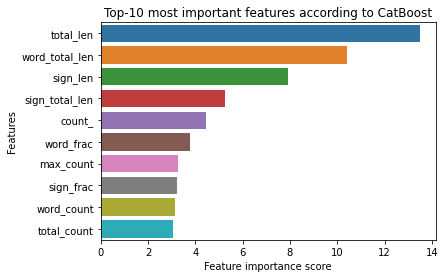

In [56]:
feature_importance_l = model_l.get_feature_importance()
feature_ranks_l = feature_importance_l.argsort()[::-1]
sns.barplot(y=X.columns[feature_ranks_l[:10]],x=feature_importance_l[feature_ranks_l[:10]])
plt.title('Top-10 most important features according to CatBoost')
plt.ylabel('Features')
plt.xlabel('Feature importance score')
plt.show()

In [57]:
params = {'loss_function':'MultiClass',
          'eval_metric':'TotalF1:average=Macro',
          'cat_features': cat_cols,
          'custom_metric':'Recall',
          'class_weights': class_weights_v,
          'verbose': 200,
          'random_seed': 0,
          'iterations': 100000,
          'depth': 4,
          'l2_leaf_reg': 1000,
          'random_strength': 1000,
         }
model_v = CatBoostClassifier(**params)
model_v.fit(X_v_train, y_v_train,
          eval_set=(X_v_test, y_v_test),
          use_best_model=True,
          plot=True
         )

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.3737749	test: 0.3787570	best: 0.3787570 (0)	total: 11.2ms	remaining: 18m 35s
200:	learn: 0.5915331	test: 0.6162926	best: 0.6270624 (54)	total: 2.11s	remaining: 17m 26s
400:	learn: 0.6049476	test: 0.6273247	best: 0.6314471 (296)	total: 3.96s	remaining: 16m 22s
600:	learn: 0.6908596	test: 0.6829497	best: 0.7067354 (436)	total: 5.88s	remaining: 16m 11s
800:	learn: 0.7415921	test: 0.7349102	best: 0.7349102 (799)	total: 7.84s	remaining: 16m 12s
1000:	learn: 0.7616719	test: 0.7685860	best: 0.7693085 (999)	total: 9.83s	remaining: 16m 13s
1200:	learn: 0.7779434	test: 0.7800335	best: 0.7807720 (1146)	total: 11.8s	remaining: 16m 11s
1400:	learn: 0.7860796	test: 0.7820695	best: 0.7821145 (1292)	total: 13.8s	remaining: 16m 9s
1600:	learn: 0.7971260	test: 0.7897266	best: 0.7897266 (1594)	total: 15.8s	remaining: 16m 9s
1800:	learn: 0.7997703	test: 0.7946100	best: 0.7946100 (1766)	total: 17.8s	remaining: 16m 8s
2000:	learn: 0.8047939	test: 0.7987572	best: 0.7987897 (1938)	total: 19.7s	rem

17400:	learn: 0.8984157	test: 0.8847528	best: 0.8847528 (16947)	total: 3m 44s	remaining: 17m 44s
17600:	learn: 0.8990132	test: 0.8847528	best: 0.8847528 (16947)	total: 3m 47s	remaining: 17m 44s
17800:	learn: 0.8990132	test: 0.8847528	best: 0.8847528 (16947)	total: 3m 51s	remaining: 17m 47s
18000:	learn: 0.8995695	test: 0.8847528	best: 0.8847528 (16947)	total: 3m 54s	remaining: 17m 47s
18200:	learn: 0.9004038	test: 0.8854065	best: 0.8854065 (18043)	total: 3m 58s	remaining: 17m 52s
18400:	learn: 0.9009599	test: 0.8860600	best: 0.8860600 (18396)	total: 4m 1s	remaining: 17m 49s
18600:	learn: 0.9024325	test: 0.8873662	best: 0.8873662 (18439)	total: 4m 4s	remaining: 17m 49s
18800:	learn: 0.9024325	test: 0.8860600	best: 0.8873662 (18439)	total: 4m 8s	remaining: 17m 52s
19000:	learn: 0.9018766	test: 0.8860600	best: 0.8873662 (18439)	total: 4m 10s	remaining: 17m 49s
19200:	learn: 0.9024325	test: 0.8867132	best: 0.8873662 (18439)	total: 4m 14s	remaining: 17m 52s
19400:	learn: 0.9024325	test: 0.8

34400:	learn: 0.9180601	test: 0.8972278	best: 0.8972278 (33128)	total: 9m 8s	remaining: 17m 26s
34600:	learn: 0.9188452	test: 0.8972278	best: 0.8978774 (34438)	total: 9m 13s	remaining: 17m 26s
34800:	learn: 0.9193977	test: 0.8972278	best: 0.8978774 (34438)	total: 9m 19s	remaining: 17m 27s
35000:	learn: 0.9194418	test: 0.8972278	best: 0.8978774 (34438)	total: 9m 24s	remaining: 17m 28s
35200:	learn: 0.9194859	test: 0.8972278	best: 0.8978774 (34438)	total: 9m 28s	remaining: 17m 26s
35400:	learn: 0.9194418	test: 0.8972278	best: 0.8978774 (34438)	total: 9m 33s	remaining: 17m 26s
35600:	learn: 0.9205909	test: 0.8972278	best: 0.8978774 (34438)	total: 9m 38s	remaining: 17m 26s
35800:	learn: 0.9211433	test: 0.8972278	best: 0.8978774 (34438)	total: 9m 43s	remaining: 17m 25s
36000:	learn: 0.9214194	test: 0.8972278	best: 0.8978774 (34438)	total: 9m 48s	remaining: 17m 26s
36200:	learn: 0.9214194	test: 0.8972278	best: 0.8978774 (34438)	total: 9m 52s	remaining: 17m 24s
36400:	learn: 0.9216955	test: 0

51400:	learn: 0.9345043	test: 0.8977823	best: 0.8990804 (47468)	total: 16m 6s	remaining: 15m 13s
51600:	learn: 0.9350545	test: 0.8977823	best: 0.8990804 (47468)	total: 16m 11s	remaining: 15m 11s
51800:	learn: 0.9350545	test: 0.8977823	best: 0.8990804 (47468)	total: 16m 16s	remaining: 15m 8s
52000:	learn: 0.9353296	test: 0.8977823	best: 0.8990804 (47468)	total: 16m 22s	remaining: 15m 7s
52200:	learn: 0.9353296	test: 0.8977823	best: 0.8990804 (47468)	total: 16m 27s	remaining: 15m 4s
52400:	learn: 0.9353296	test: 0.8977823	best: 0.8990804 (47468)	total: 16m 33s	remaining: 15m 2s
52600:	learn: 0.9353296	test: 0.8977823	best: 0.8990804 (47468)	total: 16m 38s	remaining: 14m 59s
52800:	learn: 0.9353296	test: 0.8977823	best: 0.8990804 (47468)	total: 16m 45s	remaining: 14m 59s
53000:	learn: 0.9356047	test: 0.8984315	best: 0.8990804 (47468)	total: 16m 49s	remaining: 14m 55s
53200:	learn: 0.9359258	test: 0.8984315	best: 0.8990804 (47468)	total: 16m 54s	remaining: 14m 52s
53400:	learn: 0.9359258	t

68200:	learn: 0.9452720	test: 0.9004740	best: 0.9011226 (68143)	total: 24m 6s	remaining: 11m 14s
68400:	learn: 0.9449975	test: 0.9004740	best: 0.9011226 (68143)	total: 24m 14s	remaining: 11m 11s
68600:	learn: 0.9449975	test: 0.9004740	best: 0.9011226 (68143)	total: 24m 18s	remaining: 11m 7s
68800:	learn: 0.9455465	test: 0.9004740	best: 0.9011226 (68143)	total: 24m 27s	remaining: 11m 5s
69000:	learn: 0.9455465	test: 0.9004740	best: 0.9011226 (68143)	total: 24m 33s	remaining: 11m 2s
69200:	learn: 0.9458209	test: 0.9004740	best: 0.9011226 (68143)	total: 24m 36s	remaining: 10m 56s
69400:	learn: 0.9460953	test: 0.9004740	best: 0.9011226 (68143)	total: 24m 38s	remaining: 10m 51s
69600:	learn: 0.9460953	test: 0.9004740	best: 0.9011226 (68143)	total: 24m 41s	remaining: 10m 47s
69800:	learn: 0.9464168	test: 0.9004740	best: 0.9011226 (68143)	total: 24m 46s	remaining: 10m 43s
70000:	learn: 0.9466441	test: 0.9004740	best: 0.9011226 (68143)	total: 24m 53s	remaining: 10m 40s
70200:	learn: 0.9469185	

85200:	learn: 0.9540920	test: 0.9056572	best: 0.9056572 (84751)	total: 32m 46s	remaining: 5m 41s
85400:	learn: 0.9540920	test: 0.9056572	best: 0.9056572 (84751)	total: 32m 54s	remaining: 5m 37s
85600:	learn: 0.9543659	test: 0.9056572	best: 0.9056572 (84751)	total: 33m 3s	remaining: 5m 33s
85800:	learn: 0.9543659	test: 0.9056572	best: 0.9056572 (84751)	total: 33m 10s	remaining: 5m 29s
86000:	learn: 0.9546397	test: 0.9056572	best: 0.9056572 (84751)	total: 33m 21s	remaining: 5m 25s
86200:	learn: 0.9549134	test: 0.9056572	best: 0.9056572 (84751)	total: 33m 24s	remaining: 5m 20s
86400:	learn: 0.9551872	test: 0.9056572	best: 0.9056572 (84751)	total: 33m 27s	remaining: 5m 16s
86600:	learn: 0.9557347	test: 0.9056572	best: 0.9056572 (84751)	total: 33m 30s	remaining: 5m 11s
86800:	learn: 0.9560084	test: 0.9056572	best: 0.9056572 (84751)	total: 33m 32s	remaining: 5m 6s
87000:	learn: 0.9560084	test: 0.9050100	best: 0.9056572 (84751)	total: 33m 35s	remaining: 5m 1s
87200:	learn: 0.9560084	test: 0.9

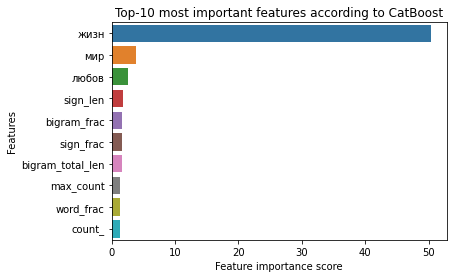

In [58]:
feature_importance_v = model_v.get_feature_importance()
feature_ranks_v = feature_importance_v.argsort()[::-1]
sns.barplot(y=X.columns[feature_ranks_v[:10]],x=feature_importance_v[feature_ranks_v[:10]])
plt.title('Top-10 most important features according to CatBoost')
plt.ylabel('Features')
plt.xlabel('Feature importance score')
plt.show()

## Предсказание на тестовых данных

In [59]:
df_test = pd.read_csv("test_dataset_test.csv")

In [60]:
df_test.head()

,RecordNo,Название книги,Автор,Ссылка на литрес,Рейтинг,Количество оценок,Количество отзывов,Имя читателя,Оценка книги читателем (из 5 баллов),Отзыв,Лайки на отзыв,Дислайки на отзыв
0,3366,Дети мои,Гузель Яхина,https://www.litres.ru/guzel-yahina/deti-moi/,4.4,8032,702,Марина Ефимкина,5.0,"Настоящая глубокая книга, коих сейчас очень не...",2,0
1,3952,Текст,Дмитрий Глуховский,https://www.litres.ru/dmitriy-gluhovskiy/tekst...,4.5,1923,246,alexvarp,5.0,Одна из лучших книг прочитанных за последние г...,1,0
2,6852,Текст,Дмитрий Глуховский,https://www.litres.ru/dmitriy-gluhovskiy/tekst/,4.4,7276,622,fb_154207611938008,5.0,"Тот случай, когда невозможно пройти мимо, не о...",0,0
3,4586,Зулейха открывает глаза,Гузель Яхина,https://www.litres.ru/guzel-yahina/zuleyha-otk...,4.6,24719,2103,Мария Курочкина,NaN,"Очень не глубокая книга. Дочитала до конца, в ...",4,0
4,4677,Зулейха открывает глаза,Гузель Яхина,https://www.litres.ru/guzel-yahina/zuleyha-otk...,4.6,24719,2103,sahnovavera,NaN,"Очень понравилась. Читается легко, о непростых...",0,1


In [63]:
df_test['latin_name'] = df_test['Имя читателя'].apply(lambda x: len(re.findall('[a-zA-Z]', x)) > 0).astype(int)

In [64]:
df_test['total_len'] = df_test['Отзыв'].fillna(' ').progress_apply(len)
df_test['Отзыв'] = df_test['Отзыв'].fillna('').progress_apply(lambda x: ' '.join(filter(lambda x: len(x) > 0, map(stem, 
                                                                                    re.split(r'[\[\]\|!\n\{\}` ,"\'\_\-.()\?=0-9//%:\~*]', 
                                                                                             x.lower())))))
df_test['sign_len'] = df_test['Отзыв'].fillna('').progress_apply(len)
df_test['sign_frac'] = df_test['sign_len']/df_test['total_len']
df_test['count_'] = df_test['Отзыв'].fillna('').progress_apply(lambda x: len(x.split()))
df_test['avg_len'] = df_test['total_len']/df_test['count_']

  0%|          | 0/2075 [00:00<?, ?it/s]

  0%|          | 0/2075 [00:00<?, ?it/s]

  0%|          | 0/2075 [00:00<?, ?it/s]

  0%|          | 0/2075 [00:00<?, ?it/s]

In [65]:
df_test = pd.concat([df_test] + [pd.DataFrame({word: df_test["Отзыв"].map(lambda x: 
                                                                                  count_instances(x, word))})
                      for word in tqdm(words)] + [pd.DataFrame({word: 
                                                                        df_test["Отзыв"].map(lambda x: 
                                                                                                count_instances(x, 
                                                                                                                word))})
                      for word in tqdm(bigrams)], axis=1)

  0%|          | 0/3141 [00:00<?, ?it/s]

  0%|          | 0/4845 [00:00<?, ?it/s]

In [66]:
df_test['word_count'] = df_test[[word for word in words]].sum(axis=1)
df_test['word_frac'] = df_test['word_count']/(df_test['count_'] +0.0001)
df_test['word_total_len'] = (df_test[[word for word in words]]*word_lengths).sum(axis=1)
df_test['word_avg_len'] = df_test['word_total_len']/(df_test['word_count'] +0.0001)

In [67]:
df_test['bigram_count'] = df_test[[word for word in bigrams]].sum(axis=1)
df_test['bigram_frac'] = df_test['bigram_count']/(df_test['count_'] +0.0001)
df_test['bigram_total_len'] = (df_test[[word for word in bigrams]]*bigram_lengths).sum(axis=1)
df_test['bigram_avg_len'] = df_test['bigram_total_len']/(df_test['bigram_count'] +0.0001)

In [68]:
df_test['total_count'] = df_test['word_count']+df_test['bigram_count']
df_test['max_count'] = df_test['word_count']-df_test['bigram_count']
df_test['sign_total_len'] = df_test['word_total_len']+df_test['bigram_total_len']
df_test['sign_avg_len'] = df_test['sign_total_len']/(df_test['total_count'] + 0.001)

In [69]:
df_test = df_test.fillna(0)
df_test = df_test.drop(columns = ['Ссылка на литрес', 'Имя читателя', 'Отзыв'])

In [70]:
df_test

,RecordNo,Название книги,Автор,Рейтинг,Количество оценок,Количество отзывов,Оценка книги читателем (из 5 баллов),Лайки на отзыв,Дислайки на отзыв,latin_name,...,word_total_len,word_avg_len,bigram_count,bigram_frac,bigram_total_len,bigram_avg_len,total_count,max_count,sign_total_len,sign_avg_len
0,3366,Дети мои,Гузель Яхина,4.4,8032,702,5.0,2,0,0,...,108,3.857129,13,0.433332,89,6.846101,41,15,197,4.804761
1,3952,Текст,Дмитрий Глуховский,4.5,1923,246,5.0,1,0,1,...,129,4.448261,11,0.343749,91,8.272652,40,18,220,5.499863
2,6852,Текст,Дмитрий Глуховский,4.4,7276,622,5.0,0,0,1,...,217,3.807011,20,0.327868,145,7.249964,77,37,362,4.701238
3,4586,Зулейха открывает глаза,Гузель Яхина,4.6,24719,2103,0.0,4,0,0,...,144,3.999989,14,0.341463,107,7.642803,50,22,251,5.019900
4,4677,Зулейха открывает глаза,Гузель Яхина,4.6,24719,2103,0.0,0,1,1,...,73,4.294092,11,0.611108,109,9.909001,28,6,182,6.499768
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2070,4661,Зулейха открывает глаза,Гузель Яхина,4.6,24719,2103,5.0,0,1,0,...,150,4.687485,18,0.562498,162,8.999950,50,14,312,6.239875
2071,1547,Дети мои,Гузель Яхина,4.4,8032,702,4.0,0,0,0,...,96,3.839985,12,0.428570,110,9.166590,37,13,206,5.567417
2072,6071,Зулейха открывает глаза,Гузель Яхина,4.6,24719,2103,5.0,0,1,1,...,176,4.399989,20,0.444443,153,7.649962,60,20,329,5.483242
2073,3805,С неба упали три яблока,Наринэ Абгарян,4.8,1455,189,5.0,0,0,0,...,127,3.342096,19,0.474999,128,6.736807,57,19,255,4.473606


In [71]:
submission = pd.read_csv('sample_solution.csv')

In [72]:
submission.head()

,RecordNo,Релевантность,Таксономия релевантные,Таксономия не релевантные,Длина отзыва,Ценности
0,3366,0,0,0,0,0
1,3952,0,0,0,0,0
2,6852,0,0,0,0,0
3,4586,0,0,0,0,0
4,4677,0,0,0,0,0


In [73]:
submission['Релевантность'] = model_r.predict(df_test)
submission['Таксономия релевантные'] = model_tr.predict(df_test)
submission['Таксономия не релевантные'] = model_tn.predict(df_test)
submission['Длина отзыва'] = model_l.predict(df_test)
submission['Ценности'] = model_v.predict(df_test)

In [74]:
submission.head()

,RecordNo,Релевантность,Таксономия релевантные,Таксономия не релевантные,Длина отзыва,Ценности
0,3366,0,0,0,1,1
1,3952,0,1,0,1,0
2,6852,0,0,0,0,1
3,4586,0,0,0,0,1
4,4677,0,1,0,0,0


In [75]:
submission.to_csv('submission.csv', index=False)